In [50]:
%matplotlib notebook
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import time

from functools import partial
from abc import ABCMeta, abstractmethod
from collections import deque
from operator import itemgetter 
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
%matplotlib inline

In [51]:
num = 11
x = np.linspace(-50, 50, num)
y = np.linspace(-50, 50, num)
x, y = np.meshgrid(x, y)

In [52]:
z = x ** 2 + y ** 2
criterion = np.min
optimum = criterion(z)

In [53]:
idx1 = np.array([[1 ,2], [2, 3]])
print(tuple(zip(*idx1)))
z[tuple(zip(*idx1))]

((1, 2), (2, 3))


array([ 2500.,  1300.])

FITNESS FUNCTIONS

In [54]:
def sigmoid_distance_fitness(f, candidate_solution, k):
    distance = abs(optimum - f[tuple(candidate_solution)])
    return 1 - (1 / (1 + np.exp(- k * distance)))


def maximize(f, point):
    return f[point]


def minimize(f, point):
    return -f[point]

NEIGHBORS FUNCTIONS

In [55]:
def l_inf_neighbors(point, shape):
    x = (-1, 0, 1)
    shifts = [p for p in itertools.product(x, repeat=len(shape))]
    points = [tuple(map(sum, zip(point, shift))) for shift in shifts]
    
    def fits_in_bounds(point):
        return all(i >= 0 for i in point) and all(p < s for p, s in zip(point, shape))
        
    return list(filter(fits_in_bounds, points))

In [56]:
l_inf_neighbors((3, 5, 4), (6, 6, 6))

[(2, 4, 3),
 (2, 4, 4),
 (2, 4, 5),
 (2, 5, 3),
 (2, 5, 4),
 (2, 5, 5),
 (3, 4, 3),
 (3, 4, 4),
 (3, 4, 5),
 (3, 5, 3),
 (3, 5, 4),
 (3, 5, 5),
 (4, 4, 3),
 (4, 4, 4),
 (4, 4, 5),
 (4, 5, 3),
 (4, 5, 4),
 (4, 5, 5)]

In [57]:
def random_neighbor(shape):
    return tuple([np.random.randint(i) for i in shape])

In [58]:
random_neighbor((34,4,4))

(15, 3, 2)

OPTIMIZATION METHODS

In [59]:
class Optimizer(metaclass=ABCMeta):
    def __init__(self, fitness, neighbors_function):
        self.fitness = fitness
        self.neighbors_function = neighbors_function

    @abstractmethod
    def optimize(self):
        raise NotImplementedError
    
    @staticmethod
    def starting_point(shape):
        return tuple(np.random.randint(i) for i in shape)

1\. GREEDY

In [60]:
class Greedy(Optimizer):
    def optimize(self, f):
        current = Optimizer.starting_point(f.shape)
        better = True
        while better:
            better = False
            for neighbor in self.neighbors_function(current, f.shape):
                neighbor_value = f[neighbor]
                if self.fitness(f, neighbor) > self.fitness(f, current):
                    yield neighbor
                    current = neighbor
                    better = True
                    break

In [61]:
g = Greedy(minimize, l_inf_neighbors)
for i in g.optimize(z):
    print(i)

(4, 4)
(4, 5)
(5, 5)


2\. STEEPEST

In [62]:
class Steepest(Optimizer):
    def optimize(self, f):
        current = Optimizer.starting_point(f.shape)
        better = True
        while better:
            better = False
            for neighbor in self.neighbors_function(current, f.shape):
                neighbor_value = f[neighbor]
                if self.fitness(f, neighbor) > self.fitness(f, current):
                    current = neighbor
                    better = True
            yield current

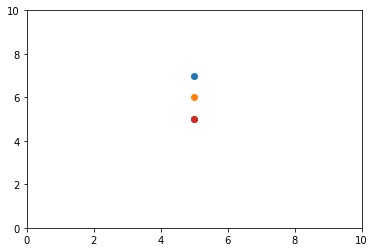

In [69]:
fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)        

for i in Steepest(minimize, l_inf_neighbors).optimize(z):
    try:
        ax.scatter(i[0], i[1])
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)
    except KeyboardInterrupt:
        break

2\. SIMULATED ANNEALING

In [86]:
class SimulatedAnnealing(Optimizer):
    
    def __init__(self, fitness, neighbors_function, temperature_0, decay_factor, steps):
        super().__init__(fitness, neighbors_function)
        self.temperature_0 = temperature_0
        self.decay_factor = decay_factor
        self.steps = steps
        self.neighbors_function = neighbors_function
        
    def optimize(self, f):
        current = Optimizer.starting_point(f.shape)
        yield current
        for step in range(steps):
            temperature = self.get_temperature(step)
            neighbor = self.neighbors_function(f.shape)
            if self.move_prob(f, current, neighbor, temperature) > np.random.random_sample():
                current = neighbor
                yield current

    
    def get_temperature(self, step):
        return self.temperature_0 * self.decay_factor ** step

    
    @staticmethod
    def nat_to_exp(q):
        max_q = max(0.0, np.max(q))
        rebased_q = q - max_q
        return np.exp(rebased_q - np.logaddexp(-max_q, np.logaddexp.reduce(rebased_q)))


    def move_prob(self, f, current, neighbor, temperature):
        d_f = self.fitness(f, neighbor) - self.fitness(f, current)
        return SimulatedAnnealing.nat_to_exp(d_f / temperature)
    #     return 1 / (1 + np.exp(- d_f / temperature))

In [87]:
temperature_0 = 10
decay_factor = 0.99
steps = 1000

simulated_annealing = SimulatedAnnealing(minimize, random_neighbor, temperature_0, decay_factor, steps)
for i in simulated_annealing.optimize(z):
    print(i)

(3, 7)
(3, 4)
(6, 4)
(5, 4)
(5, 4)
(6, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)


3\. TABU SEARCH

In [88]:
class Tabu(Optimizer):
    def __init__(self, fitness, neighbors_function, max_tabu_size, steps):
        super().__init__(fitness, neighbors_function)
        self.max_tabu_size = max_tabu_size 
        self.steps = steps
        
    def optimize(self, f):
        best = Optimizer.starting_point(f.shape)
        yield best
        candidate = best
        tabu_list = deque([], self.max_tabu_size)
        tabu_list.append(best)
        for step in range(self.steps):
            neighbors = self.neighbors_function(candidate, f.shape)
            candidate = neighbors[0]
            for neighbor in neighbors:
                neighbor =  neighbor
                if (not candidate in tabu_list) and (self.fitness(f, neighbor) > self.fitness(f, candidate)):
                    candidate = neighbor

            if self.fitness(f, candidate) > self.fitness(f, best):
                best = candidate
                yield best

            tabu_list.append(candidate)

In [89]:
tabu = Tabu(minimize, l_inf_neighbors, 5, 100)
for i in tabu.optimize(z):
    print(i)

(6, 5)
(5, 5)


4\. GENETIC ALGORITHM

In [90]:
class Operator(metaclass=ABCMeta):
    @abstractmethod
    def apply(self, f, population):
        raise NotImplementedError

In [91]:
class Mutation(Operator):
    def __init__(self, mutation_probability):
        self.mutation_probability =  mutation_probability
        
    def apply(self, f, population):
        breed = []
        for candidate_solution in population:
            for index in range(len(candidate_solution)):            
                if np.random.random_sample() < self.mutation_probability:
                    candidate_solution = list(candidate_solution)
                    candidate_solution[index] = np.random.randint(f.shape[index])
                    candidate_solution = tuple(candidate_solution)
            breed.append(candidate_solution)
        return breed


In [92]:
population = [Optimizer.starting_point(z.shape) for _ in range(20)]
print(population)
print(Mutation(0.1).apply(z, population))

[(2, 3), (3, 3), (2, 8), (10, 7), (6, 7), (2, 3), (9, 9), (2, 2), (10, 0), (6, 2), (2, 5), (4, 3), (3, 8), (9, 1), (8, 7), (4, 3), (5, 10), (6, 1), (1, 2), (2, 10)]
[(2, 3), (9, 3), (2, 8), (10, 7), (6, 7), (2, 3), (9, 9), (2, 2), (10, 0), (6, 2), (2, 5), (5, 3), (3, 8), (9, 1), (8, 7), (4, 3), (5, 10), (6, 1), (1, 2), (2, 10)]


In [93]:
class Crossover(Operator):
    def __init__(self, fitness, type_):
        self.fitness = fitness
        self.type_ = type_
        
    def select_candidate(self, population, probabilities):
        index = np.random.choice(range(len(population)), p=probabilities)
        return population[index]

    def crossover_probabilities(self, f, population):
        fitnesses = [self.fitness(f, candidate_solution) for candidate_solution in population]
        fitnesses_sum = sum(fitnesses)
        return [fitness / fitnesses_sum for fitness in fitnesses]

    def apply(self, f, population):
        breed = []
        probabilities = self.crossover_probabilities(f, population)
        while len(breed) < len(population):
            child = list(self.select_candidate(population, probabilities))
            parent = self.select_candidate(population, probabilities)
            if self.type_ == "single":
                crossover_point = np.random.randint(len(child))
                child[crossover_point:] = parent[crossover_point:]
            elif self.type_ == "double":
                crossover_point_1 = np.random.randint(child.shape[0])
                crossover_point_2 = np.random.randint(child.shape[0])
                child[crossover_point_1:crossover_point_2] = parent[crossover_point_1:crossover_point_2]
            child = tuple(child)
            breed.append(child)
        return breed

In [94]:
population_size = 10
population = [Optimizer.starting_point(z.shape) for _ in range(population_size)] + [(5,5)]
c = Crossover(partial(sigmoid_distance_fitness, k=0.005), 'single')
for (prob, point) in zip(c.crossover_probabilities(z, population), population):
    print(prob, point)

3.9521956329e-07 (7, 0)
0.295850550294 (6, 5)
0.0140944553919 (7, 7)
9.79651849831e-10 (10, 1)
0.00117636491497 (3, 2)
0.295850550294 (6, 5)
2.92029011464e-06 (9, 2)
3.55749341668e-05 (3, 1)
0.00117636491497 (3, 8)
1.08829944221e-11 (0, 10)
0.391812822756 (5, 5)


In [95]:
class Selector(metaclass=ABCMeta):
    def __init__(self, parents_size):
        self.parents_size = parents_size
        
    @abstractmethod
    def select(self, population, f, tournament_size, fitness):
        raise NotImplementedError

In [96]:
class RouletteWheel(Selector):
    def get_probs(self, population, f, fitness):
        probs = np.array([fitness(f, point) for point in population])
        probs = probs + abs(min(probs))
        probs = probs / sum(probs)
        return probs
        
    def select(self, population, f, fitness):
        probs = self.get_probs(population, f, fitness)
        indices = [np.random.choice(len(population), p=probs) for _ in range(self.parents_size)]
        return itemgetter(*indices)(population)

In [97]:
p = [Optimizer.starting_point(z.shape) for _ in range(10)]
p = [(i, i) for i in range(0, 11)]
print(RouletteWheel(5).select(p, z, minimize))

((9, 9), (4, 4), (2, 2), (8, 8), (3, 3))


In [98]:
class Tournament(Selector):
    def __init__(self, parents_size, tournament_size):
        super().__init__(parents_size)
        self.tournament_size = tournament_size
    
    def get_tournament_winner(self, population, f, fitness):
        indices = np.random.choice(len(population), self.tournament_size)
        pool = itemgetter(*indices)(population)
        return max(pool, key=partial(fitness, f))

    def select(self, population, f, fitness):
        return [self.get_tournament_winner(population, f, fitness) for _ in range(self.parents_size)]


In [99]:
p = [Optimizer.starting_point(z.shape) for _ in range(10)]
Tournament(4, 6).select(p, z, minimize)

[(6, 4), (6, 4), (8, 5), (8, 5)]

In [100]:
class Genetic(Optimizer):
    def __init__(self, fitness, steps, population_size, operators, selector):
        super().__init__(fitness, None)
        self.steps = steps
        self.population_size = population_size 
        self.operators = operators
        self.selector = selector

    def optimize(self, f):
        population = [Optimizer.starting_point(f.shape) for _ in range(self.population_size)]
        yield population
        for step in range(self.steps):
            parents = self.selector.select(population, f, self.fitness)
            for operator in self.operators:
                population = operator.apply(f, population)
            yield population

In [101]:
m = Mutation(0.1)
c = Crossover(partial(sigmoid_distance_fitness, k=0.005), 'single')
t = Tournament(5, 50)
steps = 100
population_size = 100
g = Genetic(minimize, steps, population_size, [m, c], t)
for i in g.optimize(z):
    print(i)

[(10, 7), (5, 6), (2, 5), (10, 8), (8, 2), (1, 3), (7, 9), (4, 5), (5, 4), (9, 4), (9, 2), (0, 5), (10, 2), (1, 6), (4, 4), (10, 3), (1, 4), (3, 9), (6, 6), (8, 1), (9, 6), (3, 8), (1, 8), (0, 8), (7, 5), (4, 0), (6, 1), (0, 5), (10, 4), (2, 2), (4, 8), (2, 6), (3, 9), (0, 8), (0, 10), (6, 3), (10, 2), (4, 9), (2, 2), (7, 0), (9, 6), (0, 7), (2, 6), (10, 8), (1, 3), (1, 3), (4, 4), (1, 5), (2, 1), (1, 1), (6, 2), (8, 5), (2, 3), (6, 7), (0, 5), (3, 6), (1, 7), (2, 10), (3, 1), (0, 3), (4, 5), (4, 8), (7, 2), (1, 5), (1, 4), (10, 8), (4, 3), (10, 7), (10, 6), (3, 4), (3, 5), (5, 7), (2, 0), (9, 4), (4, 10), (7, 4), (7, 6), (10, 6), (1, 8), (5, 0), (1, 2), (9, 5), (9, 5), (9, 1), (2, 1), (9, 7), (2, 6), (0, 4), (8, 0), (9, 3), (9, 5), (3, 1), (7, 8), (0, 9), (8, 8), (3, 10), (1, 8), (4, 5), (4, 10), (6, 6)]
[(4, 4), (5, 6), (5, 6), (4, 5), (6, 6), (5, 4), (4, 4), (7, 5), (4, 6), (5, 7), (4, 5), (5, 6), (5, 4), (6, 6), (6, 6), (7, 5), (4, 5), (5, 5), (4, 4), (6, 4), (5, 6), (3, 8), (5, 8)

<IPython.core.display.Javascript object>


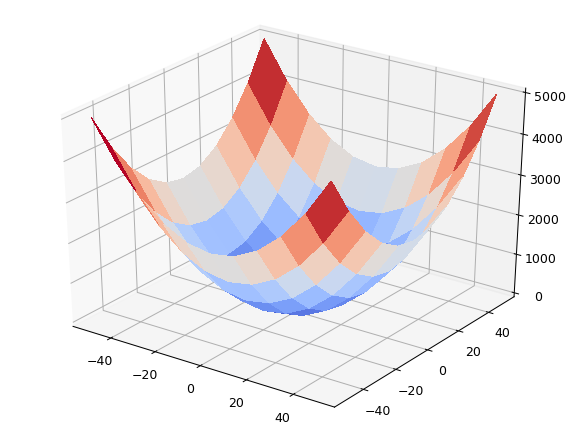

In [104]:
fig = plt.figure()
Axes3D(fig).plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [103]:
# fig = plt.figure()

# ax = Axes3D(fig)
# surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
# def init():
#     ax.view_init(elev=10., azim=0)
#     return (surf,)

# def animate(i):
#     ax.view_init(elev=10., azim=i)
#     return (surf,)

# matplotlib.rcParams['animation.writer'] = 'avconv'
# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
# HTML(anim.to_html5_video())